In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import seaborn as sns
import os
import sys
import pickle
from glob import glob

sys.path.append('../../benchmarks_unknown/')
from benchmark_functions import DejongConstr, BraninConstr, HyperEllipsoidConstr, StyblinskiTangConstr
from benchmark_functions import CatDejongConstr, CatMichalewiczConstr, CatSlopeConstr, CatCamelConstr
from utils import (
    collect_results_cat, 
    collect_results_cont, 
    collect_results_cont_abl,
    collect_results_cat_abl,
)


sns.set(style='ticks', context='notebook', font_scale=1.2)
from cmcrameri import cm

In [3]:
# Golem colormap
_reference_colors = ['#008080', '#70a494', '#b4c8a8', '#f6edbd', '#edbb8a', '#de8a5a','#ca562c']
_cmap = LinearSegmentedColormap.from_list('golem', _reference_colors)
_cmap_r = LinearSegmentedColormap.from_list('golem_r', _reference_colors[::-1])
# plt.register_cmap(cmap=_cmap)
# plt.register_cmap(cmap=_cmap_r)

# NOTE: FOR ATLAS ONLY
cmap = cm.nuuk

def get_golem_colors(n):
    _cmap = plt.get_cmap('golem')
    return [_cmap(x) for x in np.linspace(0, 1, n)]

def plot_contour(ax, X0, X1, y, xlims, ylims, vlims=[None, None], alpha=0.5, contour_lines=True, contour_labels=True, 
                 labels_fs=8, labels_fmt='%d', n_contour_lines=8, contour_color='k', contour_alpha=1, cbar=False, cmap='RdBu'):#'RdBu'):
    # background surface
    if contour_lines is True:
        contours = ax.contour(X0, X1, y, n_contour_lines, colors=contour_color, alpha=contour_alpha, linestyles='dashed')
        if contour_labels is True:
            _ = ax.clabel(contours, inline=True, fontsize=labels_fs, fmt=labels_fmt)
    mappable = ax.imshow(y, extent=[xlims[0],xlims[1],ylims[0],ylims[1]], 
                         origin='lower', cmap=cmap, alpha=alpha, vmin=vlims[0], vmax=vlims[1])
    
    if cbar is True:
        cbar = plt.colorbar(mappable=mappable, ax=ax, shrink=0.5)
        
    return mappable

def plot_constr_surface(surface, ax=None, N=100):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

    x0 = np.linspace(0,1,N)
    x1 = np.linspace(0,1,N)
    X0, X1 = np.meshgrid(x0,x1)
    X = np.array([X0.flatten(), X1.flatten()]).T
    y = np.array(surface.run(X)).flatten()
    Y = np.reshape(y, newshape=np.shape(X0))

    _ = plot_contour(ax, X0, X1, Y, xlims=[0,1], ylims=[0,1], alpha=1, contour_lines=True, contour_labels=True, 
                 labels_fs=8, labels_fmt='%d', n_contour_lines=8, contour_alpha=0.8, cbar=False, cmap='RdBu')#'RdBu') #'golem'
    for param in surface.minima:
        x_min = param['params']
        ax.scatter(x_min[0], x_min[1], s=200, marker='*', color='#ffc6ff', zorder=20)
    
    y_feas = np.array(surface.eval_constr(X))
    Y_feas = np.reshape(y_feas, newshape=np.shape(X0))
    ax.imshow(Y_feas, extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.5, interpolation='none')
    
    
def plot_constr_surface_cat(surface, ax=None, mark_min=False):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
        
        
    domain = np.arange(21)
    Z = np.zeros((21, 21))
    Z_feas = np.empty((21, 21))
    X = []
    for x_index, x in enumerate(domain):
        for y_index, y in enumerate(domain):
            x = ['x_{}'.format(x_index), 'x_{}'.format(y_index)]
            X.append(x)
            loss_value = surface.run(x)
            feas_bool = surface.eval_constr([x])
            Z[y_index, x_index] = loss_value
            #print(loss_value)
            #print(feas_bool)
            #print(x)
            Z_feas[y_index, x_index] = all(feas_bool)
            
    # scale Camel for visualization 
    if type(surface).__name__ == 'CatCamelConstr':
        Z = np.log(Z)

    ax.imshow(Z, origin='lower', cmap = plt.get_cmap('RdBu'))#'RdBu'))
    ax.imshow(Z_feas, origin='lower', cmap='gray', alpha=0.5, interpolation='none')
    
    if mark_min is True:
        X_best = surface.str2array(surface.best)
        _ = ax.scatter(X_best[0], X_best[1], marker='*', s=200, color='#ffc6ff', linewidth=2, zorder=20)
        
        
def plot_constr_surface_with_scatter(ax, surface, data, repeat=0):

    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
    plot_constr_surface(surface, ax=ax, N=100)

    repeat = 0
    X = data[repeat].loc[:, ['x0', 'x1']]
    mask = surface.eval_constr(X.to_numpy())
    X_feas = X[mask]
    X_infs = X[~mask]

    ax.scatter(X_feas['x0'], X_feas['x1'], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)
    ax.scatter(X_infs['x0'], X_infs['x1'], marker='X', s=100, color='white', edgecolor='k', zorder=10)
    
def calc_frac_feasible(surface, N=10000, categorical=False):
    if categorical is False:
        X = np.random.uniform(0, 1, size=(N, 2))
        y_feas = np.array(surface.eval_constr(X))
    else:
        domain = np.arange(surface.num_opts)
        y_feas = []
        for x_index, x in enumerate(domain):
            for y_index, y in enumerate(domain):
                x = ['x_{}'.format(x_index), 'x_{}'.format(y_index)]
                feas_bool = surface.eval_constr(x)
                y_feas.append(feas_bool)
    return sum(y_feas) / len(y_feas)


def plot_binary_scatter(surface, pkl_file, ax, n=0):
    with open(pkl_file, 'rb') as content:
        data = pickle.load(content)
    X = data[n].loc[:, ['x0', 'x1']]
    mask = surface.eval_constr(X.to_numpy())
    X_feas = X[mask]
    X_infs = X[~mask]
    
    ax.scatter(X_feas['x0'], X_feas['x1'], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)
    ax.scatter(X_infs['x0'], X_infs['x1'], marker='X', s=100, color='white', edgecolor='k', zorder=10)
    

    
def plot_binary_scatter_cat(surface, pkl_file, ax, n=0):
    with open(pkl_file, 'rb') as content:
        data = pickle.load(content)
    X = data[n].loc[:, ['x0', 'x1']]
    mask = surface.eval_constr(X.to_numpy())
    X_feas_ = X[mask].values
    X_infs_ = X[~mask].values
    
    X_feas = []
    for x_ in X_feas_:
        x = [int(x_[0][2:]), int(x_[1][2:])]
        X_feas.append(x)
    
    X_infs = []
    for x_ in X_infs_:
        x = [int(x_[0][2:]), int(x_[1][2:])]
        X_infs.append(x)

    X_infs = np.array(X_infs)
    X_feas = np.array(X_feas)
    
    ax.scatter(X_feas[:,0], X_feas[:,1], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)
    ax.scatter(X_infs[:,0], X_infs[:,1], marker='X', s=100, color='white', edgecolor='k', zorder=10)
    

In [4]:
# fig, ax = plt.subplots()
# surf = CatCamelConstr()
# plot_constr_surface_cat(surf, ax=ax, mark_min=True)
# # plot_binary_scatter_cat( surf, '../../benchmarks_unknown/cat-camel/desc_botorch_fca-0.2/results.pkl', ax, n=3)
# plot_binary_scatter_cat( surf, '../../benchmarks_unknown/cat-camel/desc_botorch_fca-0.2/results.pkl', ax, n=3)

In [5]:
color_map = {
    # naive strategies
    'naive-0': '#c7f9cc',
    'naive-fia-1000': '#57cc99',
    'naive-replace': '#2d6a4e',
    # FWA
    'fwa-0': '#ff9b85',
    # FCA
    'fca-0.2': '#fbe9b1',
    'fca-0.5': '#f4cb48',
    'fca-0.8': '#ae870b',
    # FIA
    'fia-0.5': '#caf0f8',
    'fia-1': '#03b4d8',
    'fia-2': '#0177b6',
}

## Continuous surfaces results

Branin, Dejong, Styblinski, Hyperellips

hplc_6d, ackleypath_5d


In [6]:
# fig, ax = plt.subplots()
# surface = CatCamelConstr()
# plot_constr_surface_cat(surface, ax=ax, )

In [ ]:
fig, ax = plt.subplots()
surface = BraninConstr()
plot_constr_surface(surface, ax=ax, N=100)
plot_binary_scatter(surface, '../../benchmarks_unknown/branin/botorch_ucb_fia-0.5/results.pkl', ax, n=8)
#plot_binary_scatter('../../benchmarks_unknown/branin/botorch_naive-0/results.pkl', ax, n=6)
#plot_binary_scatter('../../benchmarks_unknown/branin/botorch_fia-0.5/results.pkl', ax, n=10)
# plot_binary_scatter('../../benchmarks_unknown/branin/botorch_fia-1/results.pkl', ax, n=7)
#plot_binary_scatter('../../benchmarks_unknown/branin/botorch_fia-2/results.pkl', ax, n=2)
#plot_binary_scatter('../../benchmarks_unknown/branin/botorch_naive-fia-1000/results.pkl', ax, n=2)
#plot_binary_scatter('../../benchmarks_unknown/branin/botorch_fca-0.2/results.pkl', ax, n=0)
#plot_binary_scatter('../../benchmarks_unknown/branin/botorch_fca-0.8/results.pkl', ax, n=0)
# plt.savefig('naive-fia-1000_issues_example_1.png', dpi=300)

In [ ]:
fig, ax = plt.subplots()
surface = DejongConstr()
plot_constr_surface(surface, ax=ax, N=100)
#plot_binary_scatter('../../benchmarks_unknown/dejong/botorch_ucb_fca-0.2/results.pkl', ax)
#plot_binary_scatter('../../benchmarks_unknown/dejong/botorch_ucb_fia-0.5/results.pkl', ax)
#plot_binary_scatter('../../benchmarks_unknown/dejong/botorch_ucb_fia-1/results.pkl', ax)
#plot_binary_scatter('../../benchmarks_unknown/dejong/botorch_ucb_fia-2/results.pkl', ax)
#plot_binary_scatter('../../benchmarks_unknown/dejong/botorch_ucb_fwa-0/results.pkl', ax)
#plot_binary_scatter('../../benchmarks_unknown/dejong/botorch_ucb_naive-0/results.pkl', ax)

In [ ]:
fig, ax = plt.subplots()
surface = BraninConstr()
plot_constr_surface(surface, ax=ax, N=100)
#plot_binary_scatter('../../benchmarks_unknown/branin/botorch_ucb_fca-0.2/results.pkl', ax, n=0)
#plot_binary_scatter('../../benchmarks_unknown/branin/botorch_ucb_fia-0.5/results.pkl', ax, n=11)
#plot_binary_scatter('../../benchmarks_unknown/branin/botorch_ucb_fia-1/results.pkl', ax)
plot_binary_scatter('../../benchmarks_unknown/branin/botorch_ucb_fia-2/results.pkl', ax, n=14)
#plot_binary_scatter('../../benchmarks_unknown/branin/botorch_ucb_fwa-0/results.pkl', ax, n=4)
#plot_binary_scatter('../../benchmarks_unknown/branin/botorch_ucb_naive-0/results.pkl', ax, n=6)
#plot_binary_scatter('../../benchmarks_unknown/branin/botorch_ucb_naive-fia-1000/results.pkl', ax)

In [ ]:
# look at problematic results
res_list = pickle.load(open('../../benchmarks_unknown/branin/botorch_ucb_fia-2/results.pkl', 'rb'))
res = res_list[14]

In [ ]:
res[]

In [ ]:
res[:10]

In [56]:
arr = np.array([[0.,2.8, 1.0],[0.5,5.8, 1.6],[3.0,0.8, 2.3]])
np.sum(arr, axis=1)

array([3.8, 7.9, 6.1])

In [6]:
def get_traces_min(data, replace_nan=True):
    traces_min = []
    for df in data:
        trace = df.loc[:, 'obj'].to_numpy()
        # if first is nan, replace with first non-nan
        if replace_nan is True:
            if np.isnan(trace[0]):
                for val in trace[1:]:
                    if not np.isnan(val):
                        trace[0] = val
                        break
        trace_min = [np.nanmin(trace[:i+1]) for i in range(len(trace))]
        traces_min.append(trace_min)
    return np.array(traces_min)


def get_traces_max(data, replace_nan=True):
    traces_max = []
    for df in data:
        trace = df.loc[:, 'obj'].to_numpy()
        # if first is nan, replace with first non-nan
        if replace_nan is True:
            if np.isnan(trace[0]):
                for val in trace[1:]:
                    if not np.isnan(val):
                        trace[0] = val
                        break
        trace_max = [np.nanmax(trace[:i+1]) for i in range(len(trace))]
        traces_max.append(trace_max)
    return np.array(traces_max)


def get_traces_min_for_categorical(data, replace_nan=True):
    traces_min = []
    for df in data:
        trace = np.zeros(100)  # up to 100
        results = df.loc[:, 'obj'].to_numpy()[:100]  # up to 100
        trace[:len(results)] = results
        
        # if first is nan, replace with first non-nan
        if replace_nan is True:
            if np.isnan(trace[0]):
                for val in trace[1:]:
                    if not np.isnan(val):
                        trace[0] = val
                        break
        trace_min = [np.nanmin(trace[:i+1]) for i in range(len(trace))]
        traces_min.append(trace_min)
    return np.array(traces_min)


def plot_min_trace_mean(
    data, ax=None, color=None, label=None, categorical=False, stde=False, unc=True, shift=0.0, maximize=False,
    linewidth=4, 
):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
    
    if not maximize:
        if categorical is True:
            traces_min = get_traces_min_for_categorical(data) - shift
        else:
            traces_min = get_traces_min(data) - shift
    else:
        traces_min = get_traces_max(data)-shift
    
    mean = np.nanmean(traces_min, axis=0)
    if stde is True:
        # standard error
        stde = np.nanstd(traces_min, axis=0, ddof=1) / np.sqrt(np.shape(traces_min)[0] - 1)
    else:
        # standard deviation
        stde = np.nanstd(traces_min, axis=0, ddof=1)
        
    x = range(1, np.shape(traces_min)[1]+1, 1)

    ax.plot(x, mean, color='#444444', linewidth=linewidth+1)
    plot_ = ax.plot(x, mean, color=color, linewidth=linewidth, label=label)
    
    if unc is True:
        ax.fill_between(x, y1=mean - 1.96*stde, y2=mean + 1.96*stde, alpha=0.2, color=color)
        ax.plot(x, mean - 1.96*stde, color=color, linewidth=1, alpha=0.5)
        ax.plot(x, mean + 1.96*stde, color=color, linewidth=1, alpha=0.5)
        
    return plot_
        
    
def plot_min_trace_median(
    data, maximize=False, ax=None, color=None, label=None, shift=0.0, unc=True, nboots=1000, categorical=False,
    linewidth=4,
):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
        
    if not maximize:
        if categorical is True:
            traces_min = get_traces_min_for_categorical(data) - shift
        else:
            traces_min = get_traces_min(data) - shift
    else:
        traces_min = get_traces_max(data)-shift
        
    traces_min = get_traces_min(data, replace_nan=True)

    median = np.median(traces_min, axis=0)
    q100, q75, q25, q0 = bootstrapped_iqr(traces_min, nboots=1000)
    x = range(1, np.shape(traces_min)[1] + 1, 1)

    ax.plot(x, median, color='#444444', linewidth=linewidth+1)
    plot_ = ax.plot(x, median, color=color, label=label, lw=linewidth)
    
    
    if unc is True:
        ax.fill_between(x, y1=q25, y2=q75, alpha=0.2, color=color)
        ax.fill_between(x, y1=q0, y2=q100, alpha=0.2, color=color)
        
    return plot_
        
    
    
def plot_indiv_traces(
    data, ax=None, color=None, label=None, categorical=False, shift=0.0, maximize=False,
):
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
        
    if not maximize:
        if categorical is True:
            traces_min = get_traces_min_for_categorical(data) - shift
        else:
            traces_min = get_traces_min(data) - shift
    else:
        traces_min = get_traces_max(data)-shift
        
    x = range(1, np.shape(traces_min)[1]+1, 1)
    
    for trace in traces_min:
        
        ax.plot(x, trace, color=color, linewidth=1, alpha=0.5)
        
    
    
    
def bootstrapped_iqr(traces, nboots=100):
    boot_medians = []
    for b in range(nboots):
        boot_idx = np.random.randint(low=0, high=traces.shape[0], size=traces.shape[0])
        boot_traces = traces[boot_idx]
        boot_median = np.median(boot_traces, axis=0)
        boot_medians.append(boot_median)
        
    q75, q25 = np.percentile(np.array(boot_medians), [75 ,25], axis=0)
    q100 = np.max(traces, axis=0)
    q0 = np.min(traces, axis=0)
    return q100, q75, q25, q0

    
def get_cumulative(data):
    traces_min = get_traces_min(data)
    
    # if first merit is NaN, replace with next
    for i, trace in enumerate(traces_min):
        for j, merit in enumerate(trace):
            if np.isnan(merit) == True:
                found = False
                jdelta = 1
                # find first non-nan
                while found is False:
                    if np.isnan(traces_min[i, j+jdelta]) == False:
                        traces_min[i, j] = traces_min[i, j+jdelta]
                        found = True
                    else:
                        jdelta += 1
    
    sum_min = np.sum(traces_min, axis=1) 
    mean_min = np.mean(sum_min) 
    serr_min = np.std(sum_min) / np.sqrt(len(sum_min) - 1)
    return mean_min, serr_min

def number_of_nans(data, normalize=False):
    """normalise == True returns fraction of NaN instead of number of NaN"""
    num_nans = []
    for repeat in data:
        num_nans_i = sum(np.isnan(repeat['obj']))
        if normalize is True:
            num_nans_i = num_nans_i / len(repeat['obj'])
        num_nans.append(num_nans_i)
    return num_nans

def make_regret_df(all_data, shift=0.0, normalize=False, maximize=False):

    frame = {
        'method': [], 'planner': [], 'strategy': [], 'params': [], 
        'acqf': [], 'desc': [], 'cumulative_regrets': [], 'instant_regret_100':[], 'num_nans': [],
        'per_nans': [],
    }
    # 'instant_regret_100': [],

    for idx, data in enumerate(all_data):
        print(f'method : {data["method"]} [{idx+1} / {len(all_data)}]')
        if maximize:
            traces = get_traces_max(data['data']) - shift
        else:
            traces = get_traces_min(data['data']) - shift
        instant_regret_100 = traces[:, -1]
        cumulative_regrets = np.sum(traces[:, 10:], axis=1) # sums rows corresponding to indiv runs 
        num_nans = number_of_nans(data['data'], normalize=False)
        per_nans = np.array(number_of_nans(data['data'], normalize=True))* 100.
        #print(per_nans)
        assert len(cumulative_regrets)==len(num_nans)
        
        frame['method'].extend( [data['method']]*len(cumulative_regrets) )
        frame['planner'].extend( [data['planner']]*len(cumulative_regrets) )
        frame['strategy'].extend( [data['strategy']]*len(cumulative_regrets) )
        frame['params'].extend( [data['params']]*len(cumulative_regrets) )
        frame['acqf'].extend( [data['acqf']]*len(cumulative_regrets))
        frame['desc'].extend( [data['desc']]*len(cumulative_regrets))
        frame['cumulative_regrets'].extend(list(cumulative_regrets))
        frame['num_nans'].extend(num_nans)
        frame['per_nans'].extend(list(per_nans))
        frame['instant_regret_100'].extend(list(instant_regret_100))
        
    # normalize
    if normalize:
        regret_list = np.array(frame['cumulative_regrets'])
        regret_list_norm = (regret_list - regret_list.min()) / (regret_list.max() - regret_list.min())
        frame['cumulative_regrets'] = regret_list_norm
        
    return pd.DataFrame(frame)

In [7]:

exp_names_cont = [
        #--------
        # RANDOM
        #--------
        'random',
        # -------
        # GRYFFIN
        # -------
        # naive
#         'naive-0',
#         'naive-fia-1000',
#         # fwa
#         'fwa-0',
#         # fca
#         'fca-0.2',
#         'fca-0.5',
#         'fca-0.8',
#         # fia
#         'fca-0.5',
#         'fca-1',
#         'fca-2',
        # ------
        # ATLAS
        # ------
        # naive ei
#         'botorch_naive-0',
#         'botorch_naive-replace',
#         'botorch_naive-fia-1000',
#         # fwa ei
#         'botorch_fwa-0',
#         # fca ei
#         'botorch_fca-0.2',
#         'botorch_fca-0.5',
#         'botorch_fca-0.8',
#         # fia ei
#         'botorch_fia-0.5',
#         'botorch_fia-1',
#         'botorch_fia-2',
        # naive ucb
        'botorch_ucb_naive-0',
        'botorch_ucb_naive-replace',
        'botorch_ucb_naive-fia-1000',
        # fwa ucb
        'botorch_ucb_fwa-0',
        # fca ucb
        'botorch_ucb_fca-0.2',
        'botorch_ucb_fca-0.5',
        'botorch_ucb_fca-0.8',
        # fia ucb
        'botorch_ucb_fia-0.5',
        'botorch_ucb_fia-1',
        'botorch_ucb_fia-2',
]


dirs_cont = [
    '../../benchmarks_unknown/branin',
    '../../benchmarks_unknown/dejong',
    '../../benchmarks_unknown/styblinski',
    '../../benchmarks_unknown/hyperellips',
#     '../../benchmarks_unknown/ackleypath_5d',
#     '../../benchmarks_unknown/ackleypath_10d',
#     '../../benchmarks_unknown/schwefel_5d',
#     '../../benchmarks_unknown/schwefel_10d',
    
]

In [8]:
all_results, missing_exps, num_runs = collect_results_cont(dirs_cont, exp_names_cont, report_missing=True)
print('num missing : ', len(missing_exps))
#print(missing_exps)

>>> Unpacking branin
exp_name :  random
exp_name :  botorch_ucb_naive-0
exp_name :  botorch_ucb_naive-replace
exp_name :  botorch_ucb_naive-fia-1000
exp_name :  botorch_ucb_fwa-0
exp_name :  botorch_ucb_fca-0.2
exp_name :  botorch_ucb_fca-0.5
exp_name :  botorch_ucb_fca-0.8
exp_name :  botorch_ucb_fia-0.5
exp_name :  botorch_ucb_fia-1
exp_name :  botorch_ucb_fia-2
>>> Unpacking dejong
exp_name :  random
exp_name :  botorch_ucb_naive-0
exp_name :  botorch_ucb_naive-replace
exp_name :  botorch_ucb_naive-fia-1000
exp_name :  botorch_ucb_fwa-0
exp_name :  botorch_ucb_fca-0.2
exp_name :  botorch_ucb_fca-0.5
exp_name :  botorch_ucb_fca-0.8
exp_name :  botorch_ucb_fia-0.5
exp_name :  botorch_ucb_fia-1
exp_name :  botorch_ucb_fia-2
>>> Unpacking styblinski
exp_name :  random
exp_name :  botorch_ucb_naive-0
exp_name :  botorch_ucb_naive-replace
exp_name :  botorch_ucb_naive-fia-1000
exp_name :  botorch_ucb_fwa-0
exp_name :  botorch_ucb_fca-0.2
exp_name :  botorch_ucb_fca-0.5
exp_name :  botorch

In [100]:
[d['method'] for d in all_results['branin']]

['random',
 'botorch_ucb_naive-0',
 'botorch_ucb_naive-replace',
 'botorch_ucb_naive-fia-1000',
 'botorch_ucb_fwa-0',
 'botorch_ucb_fca-0.2',
 'botorch_ucb_fca-0.5',
 'botorch_ucb_fca-0.8',
 'botorch_ucb_fia-0.5',
 'botorch_ucb_fia-1',
 'botorch_ucb_fia-2']

In [101]:
#------------------------------
# Check the number of results
#------------------------------

strats = [
        'random',
        'naive-0', 'naive-fia-1000', 'naive-replace', 
        'fwa-0', 
        'fca-0.2', 'fca-0.5', 'fca-0.8', 
        'fia-0.5', 'fia-1', 'fia-2',
    ]

for surf in ['branin', 'dejong', 'styblinski', 'hyperellips']:
    print(f'*** {surf.upper()} ***')
    for d in all_results[surf]:
        print(f'{d["params"]} : {len(d["data"])}')
    
    print('-'*50)
    print('\n')

*** BRANIN ***
random : 100
naive-0 : 100
naive-replace : 100
naive-fia-1000 : 100
fwa-0 : 100
fca-0.2 : 100
fca-0.5 : 100
fca-0.8 : 100
fia-0.5 : 100
fia-1 : 100
fia-2 : 100
--------------------------------------------------


*** DEJONG ***
random : 100
naive-0 : 100
naive-replace : 100
naive-fia-1000 : 100
fwa-0 : 100
fca-0.2 : 100
fca-0.5 : 100
fca-0.8 : 100
fia-0.5 : 100
fia-1 : 100
fia-2 : 100
--------------------------------------------------


*** STYBLINSKI ***
random : 100
naive-0 : 100
naive-replace : 100
naive-fia-1000 : 100
fwa-0 : 100
fca-0.2 : 100
fca-0.5 : 100
fca-0.8 : 100
fia-0.5 : 100
fia-1 : 100
fia-2 : 100
--------------------------------------------------


*** HYPERELLIPS ***
random : 100
naive-0 : 100
naive-replace : 100
naive-fia-1000 : 100
fwa-0 : 100
fca-0.2 : 100
fca-0.5 : 100
fca-0.8 : 100
fia-0.5 : 100
fia-1 : 100
fia-2 : 100
--------------------------------------------------




In [9]:
normalize=False

df_branin = make_regret_df(
    all_results['branin'],
    shift=BraninConstr().minima[0]['value'],
    normalize=normalize,
)
df_dejong  = make_regret_df(
    all_results['dejong'],
    shift=DejongConstr().minima[0]['value'],
    normalize=normalize,
)
df_styblinski = make_regret_df(
    all_results['styblinski'], 
    shift=StyblinskiTangConstr().minima[0]['value'],
    normalize=normalize,
)
df_hyperellips = make_regret_df(
    all_results['hyperellips'], 
    shift=HyperEllipsoidConstr().minima[0]['value'],
    normalize=normalize,
)
# # df_ackleypath5d = make_regret_df(all_results['ackleypath_5d'], normalize=False)
# df_ackleypath10d = make_regret_df(all_results['ackleypath_10d'], normalize=False)
# # df_schwefel5d = make_regret_df(all_results['schwefel_5d'], normalize=False)
# df_schwefel10d = make_regret_df(all_results['schwefel_10d'], normalize=False)
#  HyperEllipsoidConstr, StyblinskiTangConstr

method : random [1 / 11]
method : botorch_ucb_naive-0 [2 / 11]
method : botorch_ucb_naive-replace [3 / 11]
method : botorch_ucb_naive-fia-1000 [4 / 11]
method : botorch_ucb_fwa-0 [5 / 11]
method : botorch_ucb_fca-0.2 [6 / 11]
method : botorch_ucb_fca-0.5 [7 / 11]
method : botorch_ucb_fca-0.8 [8 / 11]
method : botorch_ucb_fia-0.5 [9 / 11]
method : botorch_ucb_fia-1 [10 / 11]
method : botorch_ucb_fia-2 [11 / 11]
method : random [1 / 11]
method : botorch_ucb_naive-0 [2 / 11]
method : botorch_ucb_naive-replace [3 / 11]
method : botorch_ucb_naive-fia-1000 [4 / 11]
method : botorch_ucb_fwa-0 [5 / 11]
method : botorch_ucb_fca-0.2 [6 / 11]
method : botorch_ucb_fca-0.5 [7 / 11]
method : botorch_ucb_fca-0.8 [8 / 11]
method : botorch_ucb_fia-0.5 [9 / 11]
method : botorch_ucb_fia-1 [10 / 11]
method : botorch_ucb_fia-2 [11 / 11]
method : random [1 / 11]
method : botorch_ucb_naive-0 [2 / 11]
method : botorch_ucb_naive-replace [3 / 11]
method : botorch_ucb_naive-fia-1000 [4 / 11]
method : botorch_ucb

In [103]:
df_branin.shape

(1100, 10)

In [104]:
print('Branin')
print(BraninConstr().maxima)
print('DEJONG')
print(DejongConstr().maxima)
print('STYBLINSKI')
print(StyblinskiTangConstr().maxima)
print('HYPERELLIPSOID')
print(HyperEllipsoidConstr().maxima)

Branin
{'params': [0.0, 0.0], 'value': 308.12909601160663}
DEJONG
[{'params': [0, 0], 'value': 4.47213595499958}, {'params': [0, 1], 'value': 4.47213595499958}, {'params': [1, 0], 'value': 4.47213595499958}, {'params': [1, 1], 'value': 4.47213595499958}]
STYBLINSKI
None
HYPERELLIPSOID
[{'params': [0, 0], 'value': 75}, {'params': [0, 1], 'value': 75}, {'params': [1, 0], 'value': 75}, {'params': [1, 1], 'value': 75}]


In [105]:
df_branin

,method,planner,strategy,params,acqf,desc,cumulative_regrets,instant_regret_100,num_nans,per_nans
0,random,random,random,random,random,wodesc,130.427693,0.281213,29,29.0
1,random,random,random,random,random,wodesc,329.766729,3.099352,26,26.0
2,random,random,random,random,random,wodesc,362.119070,1.599190,28,28.0
3,random,random,random,random,random,wodesc,311.862319,0.950845,29,29.0
4,random,random,random,random,random,wodesc,562.809276,1.535660,34,34.0
...,...,...,...,...,...,...,...,...,...,...
1095,botorch_ucb_fia-2,botorch,fia,fia-2,ucb,wodesc,74.274538,0.000523,19,19.0
1096,botorch_ucb_fia-2,botorch,fia,fia-2,ucb,wodesc,10.508226,0.001646,6,6.0
1097,botorch_ucb_fia-2,botorch,fia,fia-2,ucb,wodesc,95.924186,0.000870,39,39.0
1098,botorch_ucb_fia-2,botorch,fia,fia-2,ucb,wodesc,88.945247,0.001659,12,12.0


## find the performance ranks of the strategies for the continuous tests

In [60]:
strategies = ['random', 'naive-0', 'naive-fia-1000', 'naive-replace',  'fwa-0', 
                     'fca-0.2', 'fca-0.5', 'fca-0.8', 
                     'fia-0.5', 'fia-1', 'fia-2']


strat_good_names = ['Random', 'naive-replace', 'naive-ignore', 'naive-surrogate',  
                    'FWA-0', 
                    'FCA-0.2', 'FCA-0.5', 'FCA-0.8', 
                    'FIA-0.5', 'FIA-1', 'FIA-2']

strat_name_map = dict(zip(strategies,strat_good_names))

print(strat_name_map)


def get_ranks(df_surface, surface_name):
    df_dict = {'surface': [], 'strategy': [], 'mean_rank': []}
    sub_dfs = []
    for strat in strategies:
        if strat=='random':
            sub_df = df_surface[(df_surface['params']=='random')]
        else:
            # only branin for now 
            sub_df = df_surface[(df_surface['params']==strat)&(df_surface['acqf']=='ucb')]
        sub_df['repeat'] = np.arange(100)+1
#         print(sub_df.shape)
        sub_dfs.append(sub_df)

    all_idxs_sorted = []
    ranks = dict(zip(strategies, [[] for _ in range(len(strategies))]))
    for repeat_ix in range(100):
        cumul_regrets_repeat = []
        for strat, sub_df in zip(strategies, sub_dfs):
            cumul_regrets_repeat.append(
                sub_df[sub_df['repeat']==repeat_ix+1]['cumulative_regrets'].to_numpy()[0]
            )
        idxs = np.argsort(cumul_regrets_repeat) # lowest to highest
        for rank, idx in enumerate(idxs):
            ranks[strategies[idx]].append(rank+1)


    df = pd.DataFrame(ranks)
    ranks = df.mean().to_dict()
    for key, val in ranks.items():
        df_dict['surface'].append(surface_name)
        print(key)
        print(strat_name_map[key])
        df_dict['strategy'].append(strat_name_map[key])
        df_dict['mean_rank'].append(val)
    return pd.DataFrame(df_dict)

        

{'random': 'Random', 'naive-0': 'naive-replace', 'naive-fia-1000': 'naive-ignore', 'naive-replace': 'naive-surrogate', 'fwa-0': 'FWA-0', 'fca-0.2': 'FCA-0.2', 'fca-0.5': 'FCA-0.5', 'fca-0.8': 'FCA-0.8', 'fia-0.5': 'FIA-0.5', 'fia-1': 'FIA-1', 'fia-2': 'FIA-2'}


In [61]:
ranks_branin = get_ranks(df_branin, 'Branin')
ranks_dejong = get_ranks(df_dejong, 'Dejong')
ranks_styblinski = get_ranks(df_styblinski, 'Styblinski')
ranks_hyperellips = get_ranks(df_hyperellips, 'Hyperellips')

/var/folders/b7/skyhqqz10kv5ht16t37st2pm0000gn/T/ipykernel_87583/2554402389.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['repeat'] = np.arange(100)+1
/var/folders/b7/skyhqqz10kv5ht16t37st2pm0000gn/T/ipykernel_87583/2554402389.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['repeat'] = np.arange(100)+1
/var/folders/b7/skyhqqz10kv5ht16t37st2pm0000gn/T/ipykernel_87583/2554402389.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

random
Random
naive-0
naive-replace
naive-fia-1000
naive-ignore
naive-replace
naive-surrogate
fwa-0
FWA-0
fca-0.2
FCA-0.2
fca-0.5
FCA-0.5
fca-0.8
FCA-0.8
fia-0.5
FIA-0.5
fia-1
FIA-1
fia-2
FIA-2
random
Random
naive-0
naive-replace
naive-fia-1000
naive-ignore
naive-replace
naive-surrogate
fwa-0
FWA-0
fca-0.2
FCA-0.2
fca-0.5
FCA-0.5
fca-0.8
FCA-0.8
fia-0.5
FIA-0.5
fia-1
FIA-1
fia-2
FIA-2


/var/folders/b7/skyhqqz10kv5ht16t37st2pm0000gn/T/ipykernel_87583/2554402389.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['repeat'] = np.arange(100)+1
/var/folders/b7/skyhqqz10kv5ht16t37st2pm0000gn/T/ipykernel_87583/2554402389.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['repeat'] = np.arange(100)+1
/var/folders/b7/skyhqqz10kv5ht16t37st2pm0000gn/T/ipykernel_87583/2554402389.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

random
Random
naive-0
naive-replace
naive-fia-1000
naive-ignore
naive-replace
naive-surrogate
fwa-0
FWA-0
fca-0.2
FCA-0.2
fca-0.5
FCA-0.5
fca-0.8
FCA-0.8
fia-0.5
FIA-0.5
fia-1
FIA-1
fia-2
FIA-2
random
Random
naive-0
naive-replace
naive-fia-1000
naive-ignore
naive-replace
naive-surrogate
fwa-0
FWA-0
fca-0.2
FCA-0.2
fca-0.5
FCA-0.5
fca-0.8
FCA-0.8
fia-0.5
FIA-0.5
fia-1
FIA-1
fia-2
FIA-2


In [62]:
df_ranks = pd.concat((ranks_branin,ranks_dejong,ranks_hyperellips,ranks_styblinski))
df_ranks

,surface,strategy,mean_rank
0,Branin,Random,9.15
1,Branin,naive-replace,6.12
2,Branin,naive-ignore,9.10
3,Branin,naive-surrogate,8.72
4,Branin,FWA-0,4.64
5,Branin,FCA-0.2,6.44
6,Branin,FCA-0.5,4.31
7,Branin,FCA-0.8,3.52
8,Branin,FIA-0.5,4.29
9,Branin,FIA-1,4.80


Text(13.249999999999995, 0.5, 'Strategy')

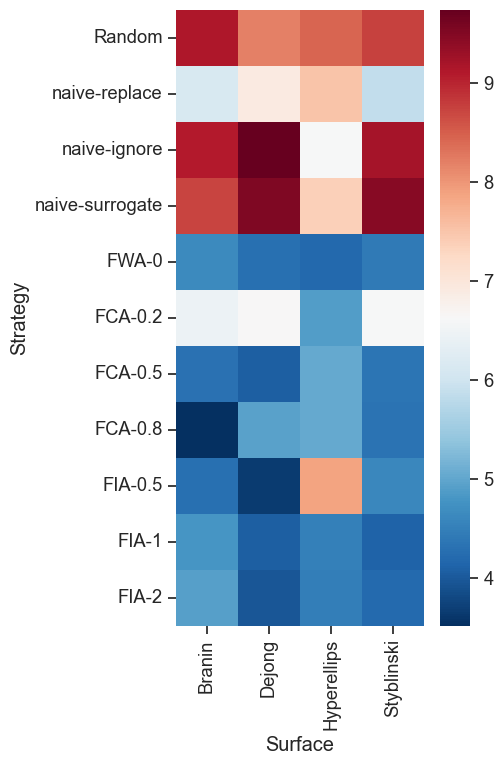

In [66]:
df_ranks_piv = df_ranks.pivot(
    index='strategy', columns='surface', values='mean_rank'
)
df_ranks_piv.index = pd.CategoricalIndex(
    df_ranks_piv.index, 
    categories=strat_good_names,
)
df_ranks_piv.sort_index(level=0, inplace=True)

#df_ranks_piv
fig, ax = plt.subplots(figsize=(4,8))
sns.heatmap(df_ranks_piv, cmap='RdBu_r')

ax.set_xlabel('Surface')
ax.set_ylabel('Strategy')

In [167]:
best = 'fwa-0'
for strat in strategies:
    _, pval = stats.ttest_ind(df[best], df[strat], equal_var=False)
    print(strat, 1.-pval)

random 1.0
naive-0 0.9999999999999418
naive-fia-1000 0.9999999329584848
naive-replace 0.9999999999947111
fwa-0 0.0
fca-0.2 0.9282783697520354
fca-0.5 0.966039425828296
fca-0.8 0.9418637419338104
fia-0.5 1.0
fia-1 0.5891061287113278
fia-2 0.5781737092589221


In [172]:
best = 'fia-2'
for strat in strategies:
    _, pval = stats.ttest_ind(
        df_hyperellips[(df_hyperellips['params']==best)&(df_hyperellips['acqf']=='ucb')]['num_nans'].to_numpy(), 
        df_hyperellips[(df_hyperellips['params']==strat)&(df_hyperellips['acqf']=='ucb')]['num_nans'].to_numpy(), 
        equal_var=False)
    print(strat, 1.-pval)

random nan
naive-0 0.9999999973930678
naive-fia-1000 1.0
naive-replace 1.0
fwa-0 0.3604247944986386
fca-0.2 0.9989062542476395
fca-0.5 0.9901528557496412
fca-0.8 0.933230616593422
fia-0.5 0.9999999997886561
fia-1 0.2786132323536832
fia-2 0.0


In [149]:
df_branin[df_branin['params']=='random']['num_nans'].mean(), df_branin[df_branin['params']=='random']['num_nans'].sem()

(27.76, 0.45374313028720153)

In [150]:
df_dejong[df_dejong['params']=='random']['num_nans'].mean(), df_dejong[df_dejong['params']=='random']['num_nans'].sem()

(45.21, 0.46412620192479037)

In [151]:
df_styblinski[df_styblinski['params']=='random']['num_nans'].mean(), df_styblinski[df_styblinski['params']=='random']['num_nans'].sem()

(55.68, 0.48029452243683596)

In [152]:
df_hyperellips[df_hyperellips['params']=='random']['num_nans'].mean(), df_hyperellips[df_hyperellips['params']=='random']['num_nans'].sem()

(45.42, 0.5822596178907332)

In [11]:
glue = sns.load_dataset("glue")#.pivot("Model", "Task", "Score")
#ns.heatmap(glue)
glue

,Model,Year,Encoder,Task,Score
0,ERNIE,2019,Transformer,CoLA,75.5
1,T5,2019,Transformer,CoLA,71.6
2,RoBERTa,2019,Transformer,CoLA,67.8
3,BERT,2018,Transformer,CoLA,60.5
4,BiLSTM+ELMo,2018,LSTM,CoLA,32.1
...,...,...,...,...,...
59,BERT,2018,Transformer,RTE,70.1
60,BiLSTM+ELMo,2018,LSTM,RTE,57.4
61,BiLSTM+CoVe,2017,LSTM,RTE,52.7
62,BiLSTM+Attn,2017,LSTM,RTE,58.4


### 

## Main-text subplots for continuous analytical tests

/var/folders/b7/skyhqqz10kv5ht16t37st2pm0000gn/T/ipykernel_85710/3799611258.py:54: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[1, ix].set_yscale('log')


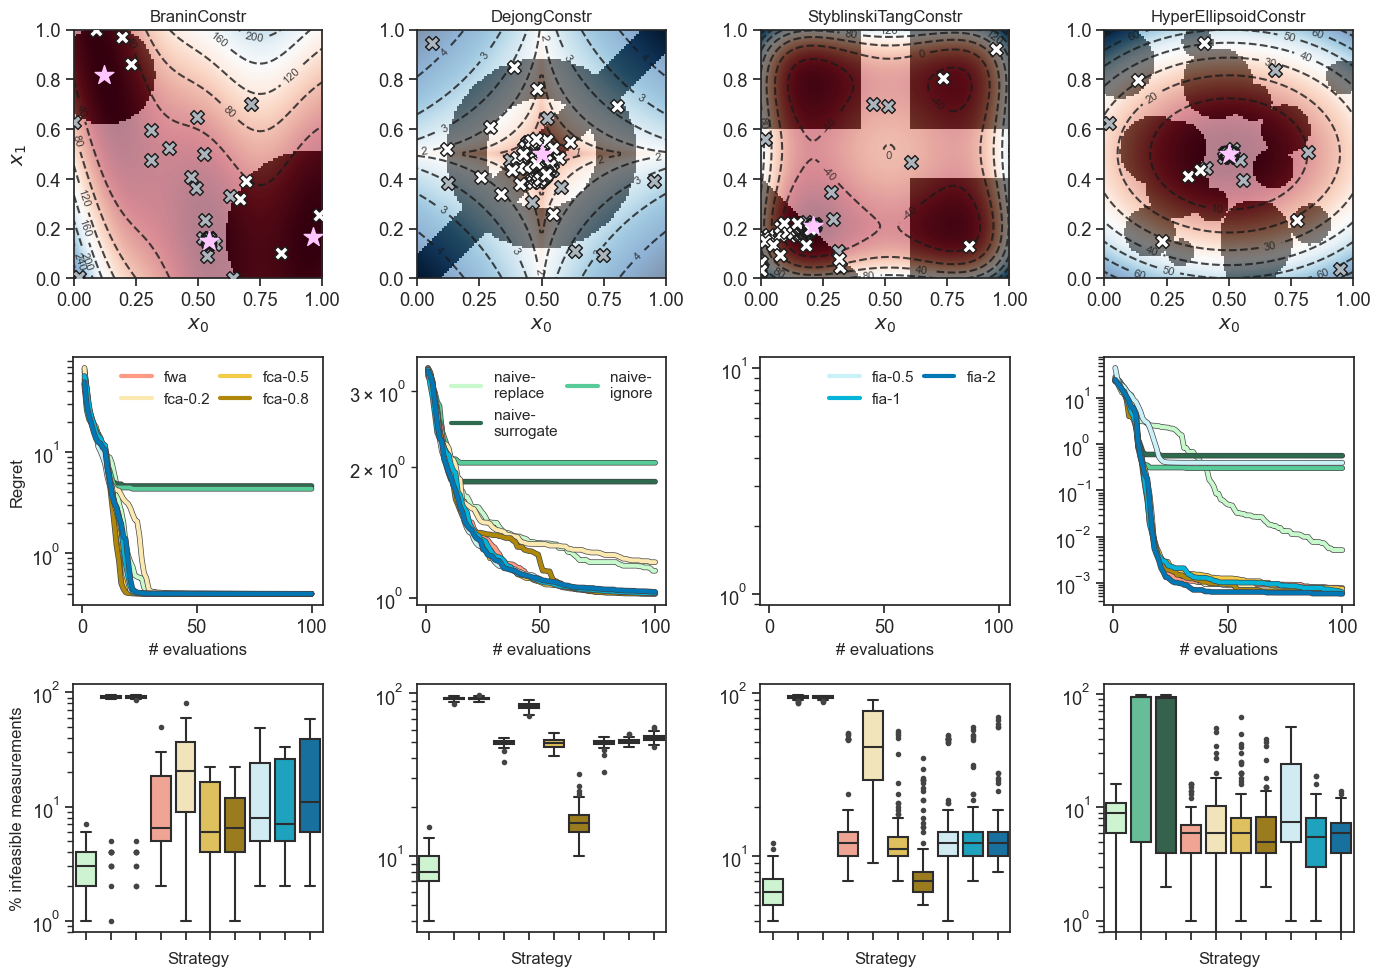

In [180]:
fig, axes = plt.subplots(3, 4, figsize=(14, 10), sharex=False, sharey=False)
# axes = axes.flatten()


surfs_short = ['branin', 'dejong', 'styblinski', 'hyperellips']
surfs_long = ['BraninConstr', 'DejongConstr', 'StyblinskiTangConstr', 'HyperEllipsoidConstr']
surfs_obj = [BraninConstr, DejongConstr, StyblinskiTangConstr, HyperEllipsoidConstr]
frames = [df_branin, df_dejong, df_styblinski, df_hyperellips]

for ix, (name_short, name_long, surf, frame) in enumerate(zip(surfs_short, surfs_long, surfs_obj, frames)):
    
    #---------------------------------------
    # plot constrained surface with samples
    #---------------------------------------
    surf_inst = surf()
    plot_constr_surface(surf_inst, ax=axes[0, ix], N=100)
    plot_binary_scatter(surf_inst, f'../../benchmarks_unknown/{name_short}/botorch_ucb_fca-0.2/results.pkl', axes[0, ix], n=0)
    axes[0, ix].set_title(name_long, fontsize=12)
    axes[0, ix].set_xlabel(r'$x_0$')
    if ix==0:
        axes[0, ix].set_ylabel(r'$x_1$')
    

    #---------------------------------------
    # plot optimization performance traces
    #---------------------------------------
    shift =  surf_inst.minima[0]['value']
    lines = []
#     print('shift : ', shift)
    for dict_ in all_results[name_short]:
        if dict_['planner']=='botorch' and dict_['acqf']=='ucb':
#             line_ = plot_min_trace_mean(
#                     dict_['data'],
#                     maximize=False,
#                     label=dict_['method'],
#                     shift=shift,
#                     ax=axes[1, ix],
#                     unc=False,
#                     color=color_map[dict_['params']],
#                     linewidth=3,
                    
#             )
            line_ = plot_min_trace_median(
                dict_['data'],
                maximize=False,
                label=dict_['method'],
                shift=shift,
                ax=axes[1, ix],
                unc=False,
                color=color_map[dict_['params']],
                linewidth=3,
            )
            lines.append(line_[0])
    axes[1, ix].set_yscale('log')
    axes[1, ix].set_xlabel('# evaluations', fontsize=12)
    if ix==0:
        axes[1, ix].set_ylabel('Regret',fontsize=12)
        
        
    #---------------------------------------
    # plot number of nans as boxplots
    #---------------------------------------
    
    frame_filter = frame[(frame['planner']=='botorch')&(frame['acqf']=='ucb')]
#     print(frame_filter.shape)
#     graph = sns.boxplot(
#                 data=frame_filter, ax=axes[2, ix], x='strategy', y='num_nans', hue='params',
#                 flierprops={'marker':'o', 'markersize':3, 
#                             'markerfacecolor':'#444444', 'markeredgecolor':'#444444'},
#         )
    
    full_palette = {
        'botorch_ucb_naive-0': '#c7f9cc', 
        'botorch_ucb_naive-replace': '#57cc99',
        'botorch_ucb_naive-fia-1000': '#2d6a4e', 
        'botorch_ucb_fwa-0': '#ff9b85',
        'botorch_ucb_fca-0.2': '#fbe9b1', 
        'botorch_ucb_fca-0.5': '#f4cb48',
        'botorch_ucb_fca-0.8': '#ae870b', 
        'botorch_ucb_fia-0.5': '#caf0f8', 
        'botorch_ucb_fia-1': '#03b4d8',
        'botorch_ucb_fia-2': '#0177b6',
    }

    g1 = sns.boxplot(
                frame_filter, ax=axes[2, ix], x='method', y='per_nans', palette=full_palette,
                flierprops={'marker':'o', 'markersize':3, 
                       'markerfacecolor':'#444444', 'markeredgecolor':'#444444'},
    )
    g1.set(xticklabels=[])
    axes[2, ix].set_xlabel('Strategy', fontsize=12)
    axes[2,ix].set_ylabel('')

#     axes[2, ix].get_legend().remove()
    axes[2, ix].set_yscale('log')
    
    

axes[2, 0].set_ylabel('% infeasible measurements',fontsize=12)    

# specify the lines and labels of the first legend
axes[1,1].legend(lines[:3], ['naive-\nreplace', 'naive-\nsurrogate', 'naive-\nignore'],
      loc='upper right', ncols=2, frameon=False, fontsize=11, columnspacing=0.6)

axes[1,0].legend(lines[3:7], ['fwa', 'fca-0.2', 'fca-0.5', 'fca-0.8'],
      loc='upper right', frameon=False, fontsize=11, ncols=2, columnspacing=0.6)

axes[1,2].legend(lines[7:10], ['fia-0.5', 'fia-1', 'fia-2'],
      loc='upper right', ncols=2, frameon=False, fontsize=11, columnspacing=0.6)


plt.tight_layout()

#plt.savefig('continuous_analytic_all.png', dpi=300)

### Make API call example results for ATLAS paper

only use the naive-0 strategy here i.e. omit the naive-replace and naive-fia-1000 strategies


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes = axes.flatten()


#---------------------------------------
# plot constrained surface with samples
#---------------------------------------
surf_inst = BraninConstr()
plot_constr_surface(surf_inst, ax=axes[0], N=100)
plot_binary_scatter(surf_inst, f'../../benchmarks_unknown/branin/botorch_ucb_fca-0.2/results.pkl', axes[0], n=0)
axes[0].set_title('BraninConstr')
axes[0].set_xlabel(r'$x_0$')
axes[0].set_ylabel(r'$x_1$')


#---------------------------------------
# plot optimization performance traces
#---------------------------------------
shift =  surf_inst.minima[0]['value']
lines = []
#     print('shift : ', shift)
for dict_ in all_results['branin']:
    if dict_['planner']=='botorch' and dict_['acqf']=='ucb' and dict_['params'] not in ['naive-replace', 'naive-fia-1000']:
        line_ = plot_min_trace_mean(
                dict_['data'],
                maximize=False,
                label=dict_['method'],
                shift=shift,
                ax=axes[1],
                unc=False,
                color=color_map[dict_['params']],
                linewidth=3,

        )
        lines.append(line_[0])
axes[1].set_yscale('log')
axes[1].set_xlabel('# evaluations')
axes[1].set_ylabel('Regret')
axes[1].set_title('Optimization performance')


#---------------------------------------
# plot number of nans as boxplots
#---------------------------------------


frame_filter = df_branin[(df_branin['planner']=='botorch')&(df_branin['acqf']=='ucb')&(~df_branin['params'].isin(['naive-replace','naive-fia-1000']))]

#     print(frame_filter.shape)
#     graph = sns.boxplot(
#                 data=frame_filter, ax=axes[2, ix], x='strategy', y='num_nans', hue='params',
#                 flierprops={'marker':'o', 'markersize':3, 
#                             'markerfacecolor':'#444444', 'markeredgecolor':'#444444'},
#         )
    
full_palette = {
    'botorch_ucb_naive-0': '#c7f9cc', 
    'botorch_ucb_naive-replace': '#57cc99',
    'botorch_ucb_naive-fia-1000': '#2d6a4e', 
    'botorch_ucb_fwa-0': '#ff9b85',
    'botorch_ucb_fca-0.2': '#fbe9b1', 
    'botorch_ucb_fca-0.5': '#f4cb48',
    'botorch_ucb_fca-0.8': '#ae870b', 
    'botorch_ucb_fia-0.5': '#caf0f8', 
    'botorch_ucb_fia-1': '#03b4d8',
    'botorch_ucb_fia-2': '#0177b6',
}

g1 = sns.boxplot(
            frame_filter, ax=axes[2], x='method', y='per_nans', palette=full_palette,
            flierprops={'marker':'o', 'markersize':3, 
                   'markerfacecolor':'#444444', 'markeredgecolor':'#444444'},
)
g1.set(xticklabels=[])
axes[2].set_xlabel('Strategy')
axes[2].set_ylabel('% infeasible measurements')

#     axes[2, ix].get_legend().remove()
axes[2].set_yscale('log')
axes[2].set_title('Feasibility performance')
  
# specify the lines and labels of the first legend
axes[1].legend(lines, ['naive-0', 'fwa', 'fca-0.2', 'fca-0.5', 'fca-0.8', 'fia-0.5', 'fia-1', 'fia-2'],
      loc='upper right', frameon=False, fontsize=11, ncols=2, columnspacing=0.6)

    
plt.tight_layout()

plt.savefig('atlas_unknown_constr_api_example.png', dpi=300)

In [69]:
def get_pvalues(
        data, 
        metric1,
        metric2,
        strategies=['random', 'botorch'],
        constraints=['naive-0', 'naive-replace', 'naive-fia-1000', 'fwa-0', 
                     'fca-0.2', 'fca-0.5', 'fca-0.8', 
                     'fia-0.5', 'fia-1', 'fia-2'],
    ):
    res = {'planner': [], 'desc': [], 'params': [], 'metric1': [], 'metric2': []}
    gb = data.groupby(by=['planner', 'desc', 'params'])
    print(gb.head())
    # random first
#     random = data[(data['planner']=='random')&(data['desc']=='wodesc')&(data['params']=='random')][metric].to_numpy()
    group = gb.get_group(('random', 'wodesc', 'random'))
    mean1 = group[metric1].mean()
    mean2 = group[metric2].mean()
    
    res['planner'].append('random')
    res['desc'].append('wodesc')
    res['params'].append('random')
    res['metric1'].append(mean1)
    res['metric2'].append(mean2)
    
    for alg in ['botorch']:
        #for desc in strategies[alg]:
        for param in constraints:
            group = gb.get_group((alg, 'wodesc', param))
            mean1 = group[metric1].mean()
            mean2 = group[metric2].mean()
            #res['method'].append()
            res['planner'].append(alg)
            res['desc'].append('wodesc')
            res['params'].append(param)
            res['metric1'].append(mean1)
            res['metric2'].append(mean2)

    #------------------------------
    # metric 1: cumulative regret
    #------------------------------
    df = pd.DataFrame(res).sort_values(by='metric1', ascending=True)
    
    signif1 = []
    
    best = df.iloc[0, :][['planner', 'desc', 'params']].tolist()
    best_res = data[
            (data['planner']==best[0])&\
            (data['desc']==best[1])&\
            (data['params']==best[2])][metric1].to_numpy()
    
    print('BEST : ', '-'.join(best))
    signif1.append(best)
    
    stop = False
    idx=1
    while not stop:
        
        new = df.iloc[idx, :][['planner', 'desc', 'params']].tolist()
        new_res = data[
            (data['planner']==new[0])&\
            (data['desc']==new[1])&\
            (data['params']==new[2])][metric1].to_numpy()
        
        print('new res : ', new_res.shape)
        _, pval = stats.ttest_ind(best_res, new_res, equal_var=False)
        
        print('NEW : ', '-'.join(new))
        print(pval)
        if pval<0.05:
            stop=True
        else:
            signif1.append(new)
            idx+=1
        
    #------------------------------
    # metric 2: num nans
    #------------------------------
    
    df = pd.DataFrame(res).sort_values(by='metric2', ascending=True)
    
    signif2 = []
    
    best = df.iloc[0, :][['planner', 'desc', 'params']].tolist()
    best_res = data[
            (data['planner']==best[0])&\
            (data['desc']==best[1])&\
            (data['params']==best[2])][metric2].to_numpy()
    
    print('BEST : ', '-'.join(best))
    signif2.append(best)
    
    stop = False
    idx=1
    while not stop:
        
        new = df.iloc[idx, :][['planner', 'desc', 'params']].tolist()
        new_res = data[
            (data['planner']==new[0])&\
            (data['desc']==new[1])&\
            (data['params']==new[2])][metric2].to_numpy()
        
        _, pval = stats.ttest_ind(best_res, new_res, equal_var=False)
        
        print('NEW : ', '-'.join(new))
        print(pval)
        if pval<0.05:
            stop=True
        else:
            signif2.append(new)
            idx+=1
        
    
    
    return signif1, signif2

In [70]:
def make_table(
#     data,
    filename='mytable.txt',
    metric1='instant_regret_100',
    metric2='num_nans',
    signif1=None, # in order of surfaces
    signif2=None,
    strategies=[
       'random', 'botorch',
    ],
    constraints=['naive-0', 'naive-replace', 'naive-fia-1000', 'fwa-0', 'fca-0.2', 'fca-0.5',
                 'fca-0.8', 'fia-0.5', 'fia-1', 'fia-2'],
    num_dec=5,
):
    ''' generate a latex table with the optimization experiment results
    '''
    
    surface_res = [df_branin,df_dejong,df_styblinski,df_hyperellips]
    
    num_rows = len(constraints)+1 # plus one for planner col
    #num_rows = np.sum([len(val) for key, val in strategies.items()])-1 # minus 1 for random sampling
    num_cols = len(surface_res)+1
    row_headers = ['planner']+constraints
    
    #col_headers = ['']+['BraninConstr', 'DejongConstr', 'StyblinskiTangConstr', 'HyperellipsoidConstr']
    col_headers = ['']+['Branin', 'Dejong', 'StyblinskiTang', 'Hyperellipsoid']

    
    col_str = ' '.join(['c' for _ in range(num_cols)])
    f = ''
    
    # table header
    f+='\\begin{table}[!ht]\n\centering\n\caption{\ldots}\n\label{\ldots}\n\\begin{tabular}{'+col_str+'}\n'
    f+= '\\toprule\n'
    f+= ' & '.join([header for header in col_headers]) + '\\\ \n'
    f+= '\midrule\n'
    
    #random sampling first
#     f+='random & '
#     gb = data.groupby(by=['planner', 'desc', 'params'])
#     group = gb.get_group(('random', 'wodesc', 'random'))
#     mean, sem = group.mean()[metric], group.sem()[metric]
#     f += f'{round(mean,num_dec)} $\pm$ {round(sem,num_dec)} & '
#     to_add = ''.join([f'$-$ & ' for _ in range(num_cols-3)])
#     f+= to_add 
#     f+= '$-$ \\\ \n'

    for alg in ['botorch']:

        for param in constraints:
                   
            f_metric1 = ''
            f_metric2 = ''
            
            for surf_ix, data in enumerate(surface_res):   
                
                gb = data.groupby(by=['planner', 'desc', 'params']) # group by method for each surface
                #group = gb.get_group((f'{alg}_ucb_{param}'))
                group = gb.get_group((alg, 'wodesc', param))
                mean1, sem1 = group[metric1].mean(), group[metric1].sem()
                mean2, sem2 = group[metric2].mean(), group[metric2].sem()
                
                print(alg, 'wodesc', param)
                print(signif1[surf_ix])
                print('')
                
                if not [alg, 'wodesc', param] in signif1[surf_ix]:
                    if surf_ix == len(surface_res)-1:
                        #f += f'${round(mean,num_dec)} \pm {round(sem,num_dec)}$ \\\ \n'
                        f_metric1 += f'${round(mean1,num_dec)} \pm {round(sem1,num_dec)}$ \\\ \n'
#                         f_metric2 += f'${round(mean2,num_dec)} \pm {round(sem2,num_dec)}$ \\\ \n'
                    else:
                        #f += f'${round(mean,num_dec)} \pm {round(sem,num_dec)}$ &'
                        f_metric1 += f'${round(mean1,num_dec)} \pm {round(sem1,num_dec)}$ &'
#                         f_metric2 += f'${round(mean2,num_dec)} \pm {round(sem2,num_dec)}$ &'
                else:
                    
                    if surf_ix == len(surface_res)-1:
                        f_metric1 +='$\\bm{'
                        f_metric1 += f'{round(mean1,num_dec)} \pm {round(sem1,num_dec)}'
                        f_metric1 += '}$ \\\ \n'
                        #-----------------------
#                         f_metric2 +='$\\bm{'
#                         f_metric2 += f'{round(mean2,num_dec)} \pm {round(sem2,num_dec)}'
#                         f_metric2 += '}$ \\\ \n'
                    else:
                        f_metric1 +='$\\bm{'
                        f_metric1 += f'{round(mean1,num_dec)} \pm {round(sem1,num_dec)}'
                        f_metric1 += '}$ & '
                        #------------------------
#                         f_metric2 +='$\\bm{'
#                         f_metric2 += f'{round(mean2,num_dec)} \pm {round(sem2,num_dec)}'
#                         f_metric2 += '}$ \\\ \n'
                        
                if not [alg, 'wodesc', param] in signif2[surf_ix]:
                    if surf_ix == len(surface_res)-1:
                
#                         f_metric1 += f'${round(mean1,num_dec)} \pm {round(sem1,num_dec)}$ \\\ \n'
                        f_metric2 += f'${round(mean2,num_dec)} \pm {round(sem2,num_dec)}$ \\\ \\hline \n'
                    else:
                      
#                         f_metric1 += f'${round(mean1,num_dec)} \pm {round(sem1,num_dec)}$ &'
                        f_metric2 += f'${round(mean2,num_dec)} \pm {round(sem2,num_dec)}$ &'
                else:
                    if surf_ix == len(surface_res)-1:
#                         f_metric1 +='$\\bm{'
#                         f_metric1 += f'{round(mean1,num_dec)} \pm {round(sem1,num_dec)}'
#                         f_metric1 += '}$ \\\ \n'
                        #-----------------------
                        f_metric2 +='$\\bm{'
                        f_metric2 += f'{round(mean2,num_dec)} \pm {round(sem2,num_dec)}'
                        f_metric2 += '}$ \\\ \\hline \n'
                    else:
#                         f_metric1 +='$\\bm{'
#                         f_metric1 += f'{round(mean1,num_dec)} \pm {round(sem1,num_dec)}'
#                         f_metric1 += '}$ & '
                        #------------------------
                        f_metric2 +='$\\bm{'
                        f_metric2 += f'{round(mean2,num_dec)} \pm {round(sem2,num_dec)}'
                        f_metric2 += '}$ &'

            f += '\\multirow{2}{*}{' #} &' 
            f += f'{param}'
            f += '} &'
            f += f'{f_metric1}'
            f += f'& {f_metric2}'
       
            
            

    # end of table
    f+='\\bottomrule\n'
    f+='\end{tabular}\n'
    f+='\end{table}\n'

    # write table to file
    with open(filename, 'w') as file:
        file.write(f)

In [64]:
signif1_branin, signif2_branin = get_pvalues(df_branin, metric1='cumulative_regrets', metric2='num_nans')
signif1_dejong, signif2_dejong = get_pvalues(df_dejong, metric1='cumulative_regrets', metric2='num_nans')
signif1_sty, signif2_sty = get_pvalues(df_styblinski, metric1='cumulative_regrets', metric2='num_nans')
#signif1_sty, signif2_sty = get_pvalues(df_d, metric1='instant_regret_100', metric2='num_nans')
signif1_hyp, signif2_hyp = get_pvalues(df_hyperellips, metric1='cumulative_regrets', metric2='num_nans')

make_table(
    filename='continuous_synthetic_instant_regret_100.txt',
    metric1='cumulative_regrets',
    metric2='num_nans',
    signif1=[signif1_branin, signif1_dejong, signif1_sty, signif1_hyp],
    signif2=[signif2_branin, signif2_dejong, signif2_sty, signif2_hyp],
    num_dec=3,
)

                          method  planner strategy          params    acqf  \
0                         random   random   random          random  random   
1                         random   random   random          random  random   
2                         random   random   random          random  random   
3                         random   random   random          random  random   
4                         random   random   random          random  random   
100          botorch_ucb_naive-0  botorch    naive         naive-0     ucb   
101          botorch_ucb_naive-0  botorch    naive         naive-0     ucb   
102          botorch_ucb_naive-0  botorch    naive         naive-0     ucb   
103          botorch_ucb_naive-0  botorch    naive         naive-0     ucb   
104          botorch_ucb_naive-0  botorch    naive         naive-0     ucb   
200    botorch_ucb_naive-replace  botorch    naive   naive-replace     ucb   
201    botorch_ucb_naive-replace  botorch    naive   naive-repla

In [52]:
df_branin

,method,planner,strategy,params,acqf,desc,cumulative_regrets,instant_regret_100,num_nans,per_nans
0,random,random,random,random,random,wodesc,253.134478,0.281213,29,29.0
1,random,random,random,random,random,wodesc,399.856452,3.099352,26,26.0
2,random,random,random,random,random,wodesc,592.148398,1.599190,28,28.0
3,random,random,random,random,random,wodesc,420.439852,0.950845,29,29.0
4,random,random,random,random,random,wodesc,859.064212,1.535660,34,34.0
...,...,...,...,...,...,...,...,...,...,...
1095,botorch_ucb_fia-2,botorch,fia,fia-2,ucb,wodesc,392.144381,0.000523,19,19.0
1096,botorch_ucb_fia-2,botorch,fia,fia-2,ucb,wodesc,264.837285,0.001646,6,6.0
1097,botorch_ucb_fia-2,botorch,fia,fia-2,ucb,wodesc,203.458446,0.000870,39,39.0
1098,botorch_ucb_fia-2,botorch,fia,fia-2,ucb,wodesc,371.085782,0.001659,12,12.0


# Categorical Benchmarks

CatSlope, CatDejong, CatMichalewicz, CatCamel

CatDejong_3d, CatMichalewicz_3d

In [ ]:
# unpack results

exp_names = [
        # -------
        # GRYFFIN
        # -------
        # naive
#         'naive_gryffin_naive-0',
#         'naive_gryffin_naive-fia-1000',
#         'static_gryffin_naive-0',
#         'static_gryffin_naive-fia-1000',
#         'dynamic_gryffin_naive-0',
#         'dynamic_gryffin_naive-fia-1000',
#         # fwa
#         'naive_gryffin_fwa-0',
#         'static_gryffin_fwa-0',
#         'dynamic_gryffin_fwa-0',
#         # fca
#         'naive_gryffin_fca-0.2',
#         'naive_gryffin_fca-0.5',
#         'naive_gryffin_fca-0.8',
#         'static_gryffin_fca-0.2',
#         'static_gryffin_fca-0.5',
#         'static_gryffin_fca-0.8',
#         'dynamic_gryffin_fca-0.2',
#         'dynamic_gryffin_fca-0.5',
#         'dynamic_gryffin_fca-0.8',
#         # fia
#         'naive_gryffin_fia-0.5',
#         'naive_gryffin_fia-1',
#         'naive_gryffin_fia-2',
#         'static_gryffin_fia-0.5',
#         'static_gryffin_fia-1',
#         'static_gryffin_fia-2',
#         'dynamic_gryffin_fia-0.5',
#         'dynamic_gryffin_fia-1',
#         'dynamic_gryffin_fia-2',
        # ------
        # ATLAS
        # ------
        # naive
#         'wodesc_botorch_naive-0',
#         'wodesc_botorch_naive-fia-1000',
#         'desc_botorch_naive-0',
#         'desc_botorch_naive-fia-1000',
#         # fwa
#         'wodesc_botorch_fwa-0',
#         'desc_botorch_fwa-0',
#         # fca
#         'wodesc_botorch_fca-0.2',
#         'wodesc_botorch_fca-0.5',
#         'wodesc_botorch_fca-0.8',
#         'desc_botorch_fca-0.2',
#         'desc_botorch_fca-0.5',
#         'desc_botorch_fca-0.8',
#         # fia
#         'wodesc_botorch_fia-0.5',
#         'wodesc_botorch_fia-1',
#         'wodesc_botorch_fia-2',
#         'desc_botorch_fia-0.5',
#         'desc_botorch_fia-1',
#         'desc_botorch_fia-2',
        
        #----------------
        # RandomSearch
        #----------------
        'random',
        #----------------
        # UCB benchmarks
        #----------------
    
        # naive ucb
        'wodesc_botorch_ucb_naive-0',
        'wodesc_botorch_ucb_naive-replace',
        'wodesc_botorch_ucb_naive-fia-1000',
        'desc_botorch_ucb_naive-0',
        'desc_botorch_ucb_naive-replace',
        'desc_botorch_ucb_naive-fia-1000',
        # fwa ucb
        'wodesc_botorch_ucb_fwa-0',
        'desc_botorch_ucb_fwa-0',
        # fca ucb
        'wodesc_botorch_ucb_fca-0.2',
        'wodesc_botorch_ucb_fca-0.5',
        'wodesc_botorch_ucb_fca-0.8',
        'desc_botorch_ucb_fca-0.2',
        'desc_botorch_ucb_fca-0.5',
        'desc_botorch_ucb_fca-0.8',
        # fia ucb
        'wodesc_botorch_ucb_fia-0.5',
        'wodesc_botorch_ucb_fia-1',
        'wodesc_botorch_ucb_fia-2',
        'desc_botorch_ucb_fia-0.5',
        'desc_botorch_ucb_fia-1',
        'desc_botorch_ucb_fia-2',
    
        #----------------
        # EI benchmarks
        #----------------
    
        # naive ei
        'wodesc_botorch_ei_naive-0',
        'wodesc_botorch_ei_naive-replace',
        'wodesc_botorch_ei_naive-fia-1000',
        'desc_botorch_ei_naive-0',
        'desc_botorch_ei_naive-replace',
        'desc_botorch_ei_naive-fia-1000',
        # fwa ucb
        'wodesc_botorch_ei_fwa-0',
        'desc_botorch_ei_fwa-0',
        # fca ucb
        'wodesc_botorch_ei_fca-0.2',
        'wodesc_botorch_ei_fca-0.5',
        'wodesc_botorch_ei_fca-0.8',
        'desc_botorch_ei_fca-0.2',
        'desc_botorch_ei_fca-0.5',
        'desc_botorch_ei_fca-0.8',
        # fia ucb
        'wodesc_botorch_ei_fia-0.5',
        'wodesc_botorch_ei_fia-1',
        'wodesc_botorch_ei_fia-2',
        'desc_botorch_ei_fia-0.5',
        'desc_botorch_ei_fia-1',
        'desc_botorch_ei_fia-2',
]

dirs = [
    '../../benchmarks_unknown/cat-camel',
    '../../benchmarks_unknown/cat-michalewicz',
    '../../benchmarks_unknown/cat-slope',
    '../../benchmarks_unknown/cat-dejong',
] 

In [ ]:
all_results, missing_exps, num_runs = collect_results_cat(dirs, exp_names, report_missing=True)
# print(len(missing_exps))
# for key, val in num_runs.items():
#     print(f'{key} : {val}')

In [ ]:
len(missing_exps)

In [ ]:
print(missing_exps)

In [ ]:
def make_num_eval_df(all_data, normalize=False):
    
    frame = {
        'method': [], 'planner': [], 'params': [], 'desc': [], 'acqf': [], 'num_evals': [], 'num_nans': [],
        'per_explore':[], 'per_nans': [],
    }

    for idx, data in enumerate(all_data):
        print(f'method : {data["method"]} [{idx+1} / {len(all_data)}]')

        num_evals = [d.shape[0] for d in data['data']]
        num_nans  = [d['obj'].isna().sum() for d in data['data']]
        
        per_explore = (np.array(num_evals) / 21**2) * 100.
        
        per_nans = (np.array(num_nans)/np.array(num_evals)) * 100.
        
        
        assert len(num_evals)==len(num_nans)
        
        frame['method'].extend( [data['method']]*len(num_evals) )
        frame['planner'].extend( [data['planner']]*len(num_evals) )
        frame['params'].extend( [data['params']]*len(num_evals) )
        frame['desc'].extend( [data['desc']]*len(num_evals))
        frame['acqf'].extend( [data['acqf']]*len(num_evals))
        frame['num_evals'].extend(num_evals)
        frame['num_nans'].extend(num_nans)
        frame['per_explore'].extend(list(per_explore))
        frame['per_nans'].extend(list(per_nans))
        
        
    return pd.DataFrame(frame)

In [ ]:
df_catslope = make_num_eval_df(all_results['cat-slope'])
df_catdejong = make_num_eval_df(all_results['cat-dejong'])
df_catcamel = make_num_eval_df(all_results['cat-camel'])
df_catmichalewicz = make_num_eval_df(all_results['cat-michalewicz'])

In [ ]:
#----------
# UCB DESC
#----------

fig, axes = plt.subplots(3, 4, figsize=(14, 10), sharex=False, sharey=False)
# axes = axes.flatten()


surfs_short = ['cat-slope', 'cat-dejong', 'cat-camel', 'cat-michalewicz']
surfs_long = ['CatSlopeConstr', 'CatDejongConstr', 'CatCamelConstr', 'CatMichalewiczConstr']
surfs_obj = [CatSlopeConstr, CatDejongConstr, CatCamelConstr, CatMichalewiczConstr]
frames = [
    df_catslope[df_catslope['acqf']=='ucb'], 
    df_catdejong[df_catdejong['acqf']=='ucb'], 
    df_catcamel[df_catcamel['acqf']=='ucb'], 
    df_catmichalewicz[df_catmichalewicz['acqf']=='ucb'],
] # ucb only

lines = []
for ix, (name_short, name_long, surf, frame) in enumerate(zip(surfs_short, surfs_long, surfs_obj, frames)):
    
    #---------------------------------------
    # plot constrained surface with samples
    #---------------------------------------
    surf_inst = surf()
    plot_constr_surface_cat(surf_inst, ax=axes[0,ix], mark_min=True)
    plot_binary_scatter_cat(
        surf_inst, f'../../benchmarks_unknown/{name_short}/desc_botorch_ucb_fwa-0/results.pkl', axes[0,ix], n=3)

    axes[0, ix].set_title(name_long, fontsize=12)
    axes[0, ix].set_xlabel(r'$x_0$')
    if ix==0:
        axes[0, ix].set_ylabel(r'$x_1$')
        
    #-------------------------------------
    # plot number of evals to get to best
    #-------------------------------------
    
    frame_filter = frame[(frame['planner']=='botorch')&(frame['acqf']=='ucb')&(frame['desc']=='desc')]
    full_palette = {
        'desc_botorch_ucb_naive-0': '#c7f9cc', 
        'desc_botorch_ucb_naive-replace': '#57cc99',
        'desc_botorch_ucb_naive-fia-1000': '#2d6a4e', 
        'desc_botorch_ucb_fwa-0': '#ff9b85',
        'desc_botorch_ucb_fca-0.2': '#fbe9b1', 
        'desc_botorch_ucb_fca-0.5': '#f4cb48',
        'desc_botorch_ucb_fca-0.8': '#ae870b', 
        'desc_botorch_ucb_fia-0.5': '#caf0f8', 
        'desc_botorch_ucb_fia-1': '#03b4d8',
        'desc_botorch_ucb_fia-2': '#0177b6',
    }

    g1 = sns.boxplot(
                frame_filter, ax=axes[1, ix], x='method', y='per_explore', palette=full_palette,
                #labels=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j'],
                flierprops={'marker':'o', 'markersize':3, 
                       'markerfacecolor':'#444444', 'markeredgecolor':'#444444'},
    )
    g1.set(xticklabels=[])
    axes[1, ix].set_xlabel('')
    axes[1,ix].set_ylabel('')
    
    
    #-------------------------------------
    # plot number of infeasible measurements
    #-------------------------------------
    
    g1 = sns.boxplot(
                frame_filter, ax=axes[2, ix], x='method', y='per_nans', palette=full_palette,
                flierprops={'marker':'o', 'markersize':3,  
                       'markerfacecolor':'#444444', 'markeredgecolor':'#444444'},
    )
    g1.set(xticklabels=[])
    axes[2, ix].set_xlabel('Strategy', fontsize=12)
    axes[2,ix].set_ylabel('')
    

axes[1, 0].set_ylabel('% explored space', fontsize=12)   
axes[2, 0].set_ylabel('% infeasible measurements',fontsize=12)


# handles, _ = axes[1,0].get_legend_handles_labels()          # Get the artists.
# ax.legend(handles, ["label1", "label2"], loc="best"

# print(handles)
# print

# axes[1,0].legend(labels=["label1", "label2"], loc='best')

# # specify the lines and labels of the first legend
# axes[1,0].legend(lines[:3], ['naive-replace', 'naive-surrogate', 'naive-ignore'],
#       loc='upper left', frameon=False, fontsize=12)

# axes[1, 2].legend(lines[3:10], ['fwa', 'fca-0.2', 'fca-0.5', 'fca-0.8', 'fia-0.5', 'fia-1', 'fia-2'],
#       loc='upper right', frameon=False, fontsize=12, ncols=2, columnspacing=0.4)

# # axes[1,2].legend(lines[7:10], ['fia-0.5', 'fia-1', 'fia-2'],
# #       loc='upper right', frameon=False, fontsize=12)


plt.tight_layout()
plt.savefig('cat_analytic_ucb_desc_all.png', dpi=350)

In [ ]:
#------------
# EI WO DESC
#------------

fig, axes = plt.subplots(3, 4, figsize=(14, 10), sharex=False, sharey=False)
# axes = axes.flatten()


surfs_short = ['cat-slope', 'cat-dejong', 'cat-camel', 'cat-michalewicz']
surfs_long = ['CatSlopeConstr', 'CatDejongConstr', 'CatCamelConstr', 'CatMichalewiczConstr']
surfs_obj = [CatSlopeConstr, CatDejongConstr, CatCamelConstr, CatMichalewiczConstr]
frames = [
    df_catslope[df_catslope['acqf']=='ucb'], 
    df_catdejong[df_catdejong['acqf']=='ucb'], 
    df_catcamel[df_catcamel['acqf']=='ucb'], 
    df_catmichalewicz[df_catmichalewicz['acqf']=='ucb'],
] # ei only

for ix, (name_short, name_long, surf, frame) in enumerate(zip(surfs_short, surfs_long, surfs_obj, frames)):
    
    #---------------------------------------
    # plot constrained surface with samples
    #---------------------------------------
    surf_inst = surf()
    plot_constr_surface_cat(surf_inst, ax=axes[0,ix], mark_min=True)
    plot_binary_scatter_cat(
        surf_inst, f'../../benchmarks_unknown/{name_short}/wodesc_botorch_ucb_fia-0.5/results.pkl', axes[0,ix], n=3)

    axes[0, ix].set_title(name_long, fontsize=12)
    axes[0, ix].set_xlabel(r'$x_0$')
    if ix==0:
        axes[0, ix].set_ylabel(r'$x_1$')
        
    #-------------------------------------
    # plot number of evals to get to best
    #-------------------------------------
    
    frame_filter = frame[(frame['planner']=='botorch')&(frame['acqf']=='ucb')&(frame['desc']=='wodesc')]
    full_palette = {
        'wodesc_botorch_ucb_naive-0': '#c7f9cc', 
        'wodesc_botorch_ucb_naive-replace': '#57cc99',
        'wodesc_botorch_ucb_naive-fia-1000': '#2d6a4e', 
        'wodesc_botorch_ucb_fwa-0': '#ff9b85',
        'wodesc_botorch_ucb_fca-0.2': '#fbe9b1', 
        'wodesc_botorch_ucb_fca-0.5': '#f4cb48',
        'wodesc_botorch_ucb_fca-0.8': '#ae870b', 
        'wodesc_botorch_ucb_fia-0.5': '#caf0f8', 
        'wodesc_botorch_ucb_fia-1': '#03b4d8',
        'wodesc_botorch_ucb_fia-2': '#0177b6',
    }

    g1 = sns.boxplot(
                frame_filter, ax=axes[1, ix], x='method', y='per_explore', palette=full_palette,
                flierprops={'marker':'o', 'markersize':3, 
                       'markerfacecolor':'#444444', 'markeredgecolor':'#444444'},
    )
    g1.set(xticklabels=[])
    axes[1, ix].set_xlabel('')
    axes[1,ix].set_ylabel('')
    
    
    #-------------------------------------
    # plot number of infeasible measurements
    #-------------------------------------
    
    g1 = sns.boxplot(
                frame_filter, ax=axes[2, ix], x='method', y='per_nans', palette=full_palette,
                flierprops={'marker':'o', 'markersize':3, 
                       'markerfacecolor':'#444444', 'markeredgecolor':'#444444'},
    )
    g1.set(xticklabels=[])
    axes[2, ix].set_xlabel('Strategy', fontsize=12)
    axes[2,ix].set_ylabel('')
    

axes[1, 0].set_ylabel('% explored space', fontsize=12)   
axes[2, 0].set_ylabel('% infeasible measurements',fontsize=12)    

# # specify the lines and labels of the first legend
# axes[1,0].legend(lines[:3], ['naive-replace', 'naive-surrogate', 'naive-ignore'],
#       loc='upper right', frameon=False, fontsize=12)

# axes[1, 1].legend(lines[3:10], ['fwa', 'fca-0.2', 'fca-0.5', 'fca-0.8', 'fia-0.5', 'fia-1', 'fia-2'],
#       loc='upper right', frameon=False, fontsize=12, ncols=2, columnspacing=0.4)

# axes[1,2].legend(lines[7:10], ['fia-0.5', 'fia-1', 'fia-2'],
#       loc='upper right', frameon=False, fontsize=12)


plt.tight_layout()
plt.savefig('cat_analytic_ucb_wodesc_all.png', dpi=350)

In [ ]:
def get_pvalues_cat(
        data, 
        desc,
        metric1,
        metric2,
        strategies=['botorch'],
        constraints=['naive-0', 'naive-replace', 'naive-fia-1000', 'fwa-0', 
                     'fca-0.2', 'fca-0.5', 'fca-0.8', 
                     'fia-0.5', 'fia-1', 'fia-2'],
    ):
    res = {'planner': [], 'desc': [], 'params': [], 'metric1': [], 'metric2': []}
    gb = data.groupby(by=['planner', 'desc', 'params'])
    # random first
    random = data[(data['planner']=='random')&(data['desc']==False)&(data['param']=='random')][metric].to_numpy()
    group = gb.get_group(('random', False, 'random'))
    mean = group.mean()[metric]
    
    res['planner'].append('random')
    res['desc'].append(False)
    res['params'].append('random')
    res['metric'].append(mean)
    
    for alg in ['botorch']:
        #for desc in strategies[alg]:
        for param in constraints:
            group = gb.get_group((alg, desc, param))
            mean1 = group[metric1].mean()
            mean2 = group[metric2].mean()
            #res['method'].append()
            res['planner'].append(alg)
            res['desc'].append(desc)
            res['params'].append(param)
            res['metric1'].append(mean1)
            res['metric2'].append(mean2)

    #------------------------------
    # metric 1: # evals
    #------------------------------
    df = pd.DataFrame(res).sort_values(by='metric1', ascending=True)
    
    signif1 = []
    
    best = df.iloc[0, :][['planner', 'desc', 'params']].tolist()
    best_res = data[
            (data['planner']==best[0])&\
            (data['desc']==best[1])&\
            (data['params']==best[2])][metric1].to_numpy()
    
#     print('BEST : ', '-'.join(best))
    signif1.append(best)
    
    stop = False
    idx=1
    while not stop:
        
        new = df.iloc[idx, :][['planner', 'desc', 'params']].tolist()
        new_res = data[
            (data['planner']==new[0])&\
            (data['desc']==new[1])&\
            (data['params']==new[2])][metric1].to_numpy()
        
        _, pval = stats.ttest_ind(best_res, new_res, equal_var=False)
        
#         print('NEW : ', '-'.join(new))
#         print(pval)
        if pval<0.05:
            stop=True
        else:
            signif1.append(new)
            idx+=1
            if len(signif1) == len(constraints):
                stop=True
        
    #------------------------------
    # metric 2: num nans
    #------------------------------
    
    df = pd.DataFrame(res).sort_values(by='metric2', ascending=True)
    
    signif2 = []
    
    best = df.iloc[0, :][['planner', 'desc', 'params']].tolist()
    best_res = data[
            (data['planner']==best[0])&\
            (data['desc']==best[1])&\
            (data['params']==best[2])][metric2].to_numpy()
    
#     print('BEST : ', '-'.join(best))
    signif2.append(best)
    
    stop = False
    idx=1
    while not stop:
        
        
        new = df.iloc[idx, :][['planner', 'desc', 'params']].tolist()
        new_res = data[
            (data['planner']==new[0])&\
            (data['desc']==new[1])&\
            (data['params']==new[2])][metric2].to_numpy()
        
        _, pval = stats.ttest_ind(best_res, new_res, equal_var=False)
        
#         print('NEW : ', '-'.join(new))
#         print(pval)
        if pval<0.05:
            stop=True
        else:
            signif2.append(new)
            idx+=1
            if len(signif2) == len(constraints):
                stop=True
        
    
    
    return signif1, signif2

In [ ]:
def make_table_cat(
#     data,
    desc='desc',
    filename='mytable.txt',
    metric1='cumulative_regrets',
    metric2='num_nans',
    signif1=None, # in order of surfaces
    signif2=None,
    strategies=[
        'botorch',
    ],
    constraints=['naive-0', 'naive-replace', 'naive-fia-1000', 'fwa-0', 'fca-0.2', 'fca-0.5',
                 'fca-0.8', 'fia-0.5', 'fia-1', 'fia-2'],
    num_dec=1,
):
    ''' generate a latex table with the optimization experiment results
    '''
    
    surface_res = [df_catslope,df_catdejong,df_catmichalewicz,df_catcamel]
    
    num_rows = len(constraints)+1 # plus one for planner col
    #num_rows = np.sum([len(val) for key, val in strategies.items()])-1 # minus 1 for random sampling
    num_cols = len(surface_res)+1
    row_headers = ['planner']+constraints
    
    #col_headers = ['']+['BraninConstr', 'DejongConstr', 'StyblinskiTangConstr', 'HyperellipsoidConstr']
    col_headers = ['']+['CatSlope', 'CatDejong', 'CatMichalewicz', 'CatCamel']

    
    col_str = ' '.join(['c' for _ in range(num_cols)])
    f = ''
    
    # table header
    f+='\\begin{table}[!ht]\n\centering\n\caption{\ldots}\n\label{\ldots}\n\\begin{tabular}{'+col_str+'}\n'
    f+= '\\toprule\n'
    f+= ' & '.join([header for header in col_headers]) + '\\\ \n'
    f+= '\midrule\n'
    
    # random sampling first
    f+='random & '
    group = gb.get_group(('random', False, 'random'))
    mean, sem = group.mean()[metric], group.sem()[metric]
    f += f'{round(mean,num_dec)} $\pm$ {round(sem,num_dec)} & '
    to_add = ''.join([f'$-$ & ' for _ in range(num_cols-3)])
    f+= to_add 
    f+= '$-$ \\\ \n'

    
        
    for alg in ['botorch']:

        for param in constraints:
            
            
            f_metric1 = ''
            f_metric2 = ''
            
            for surf_ix, data in enumerate(surface_res):   
                
                gb = data.groupby(by=['planner', 'desc', 'params']) # group by method for each surface
                #group = gb.get_group((f'{alg}_ucb_{param}'))
                group = gb.get_group((alg, desc, param))
                mean1, sem1 = group[metric1].mean(), group[metric1].sem()
                mean2, sem2 = group[metric2].mean(), group[metric2].sem()
                

                if not [alg, desc, param] in signif1[surf_ix]:
                    if surf_ix == len(surface_res)-1:
                        f_metric1 += f'${round(mean1,num_dec)} \pm {round(sem1,num_dec)}$ \\\ \n'
                    else:
                        f_metric1 += f'${round(mean1,num_dec)} \pm {round(sem1,num_dec)}$ &'
                else:
      
                    if surf_ix == len(surface_res)-1:
                        f_metric1 +='$\\bm{'
                        f_metric1 += f'{round(mean1,num_dec)} \pm {round(sem1,num_dec)}'
                        f_metric1 += '}$ \\\ \n'

                    else:
                        f_metric1 +='$\\bm{'
                        f_metric1 += f'{round(mean1,num_dec)} \pm {round(sem1,num_dec)}'
                        f_metric1 += '}$ & '

                if not [alg, desc, param] in signif2[surf_ix]:
                    if surf_ix == len(surface_res)-1:
                
                        f_metric2 += f'${round(mean2,num_dec)} \pm {round(sem2,num_dec)}$ \\\ \\hline \n'
                    else:
                        f_metric2 += f'${round(mean2,num_dec)} \pm {round(sem2,num_dec)}$ &'
                else:
                    if surf_ix == len(surface_res)-1:
                        f_metric2 +='$\\bm{'
                        f_metric2 += f'{round(mean2,num_dec)} \pm {round(sem2,num_dec)}'
                        f_metric2 += '}$ \\\ \\hline \n'
                    else:
                        f_metric2 +='$\\bm{'
                        f_metric2 += f'{round(mean2,num_dec)} \pm {round(sem2,num_dec)}'
                        f_metric2 += '}$ &'

            f += '\\multirow{2}{*}{' #} &' 
            f += f'{param}'
            f += '} &'
            f += f'{f_metric1}'
            f += f'& {f_metric2}'
       
            
            

    # end of table
    f+='\\bottomrule\n'
    f+='\end{tabular}\n'
    f+='\end{table}\n'

    # write table to file
    with open(filename, 'w') as file:
        file.write(f)

In [ ]:
#--------
# WODESC
#--------

# signif1_catcamel, signif2_catcamel = get_pvalues_cat(
#     data=df_catcamel, desc='wodesc', metric1='per_explore', metric2='per_nans',
# )
# signif1_slope, signif2_slope = get_pvalues_cat(
#     data=df_catslope, desc='wodesc', metric1='per_explore', metric2='per_nans',
# )
# signif1_mich, signif2_mich = get_pvalues_cat(
#     data=df_catmichalewicz, desc='wodesc', metric1='per_explore', metric2='per_nans',
# )
# signif1_dejong, signif2_dejong = get_pvalues_cat(
#     data=df_catdejong, desc='wodesc', metric1='per_explore', metric2='per_nans',
# )

# make_table_cat(
#     filename='categorical_synthetic.txt',
#     metric1='per_explore',
#     metric2='per_nans',
#     signif1=[signif1_slope, signif1_dejong, signif1_mich, signif1_catcamel],
#     signif2=[signif2_slope, signif2_dejong, signif2_mich, signif2_catcamel],
# )

In [ ]:
#------
# DESC
#------
signif1_catcamel, signif2_catcamel = get_pvalues_cat(
    data=df_catcamel, desc='desc', metric1='per_explore', metric2='per_nans',
)
signif1_slope, signif2_slope = get_pvalues_cat(
    data=df_catslope, desc='desc',metric1='per_explore', metric2='per_nans',
)
signif1_mich, signif2_mich = get_pvalues_cat(
    data=df_catmichalewicz, desc='desc',metric1='per_explore', metric2='per_nans',
)
signif1_dejong, signif2_dejong = get_pvalues_cat(
    data=df_catdejong, desc='desc',metric1='per_explore', metric2='per_nans',
)

make_table_cat(
    desc='desc',
    filename='categorical_synthetic_desc_1.txt',
    metric1='per_explore',
    metric2='per_nans',
    signif1=[signif1_slope, signif1_dejong, signif1_mich, signif1_catcamel],
    signif2=[signif2_slope, signif2_dejong, signif2_mich, signif2_catcamel],
)

In [ ]:
df_catcamel[df_catcamel['planner']=='random']

In [ ]:
signif2_catcamel